In [30]:
import pandas as pd
import numpy as np
import ast
from typing import List
from pathlib import Path
from tweets_cleaning import ekphrasis_clean
from confusion_matrix_utils import plot_confusion_matrix

from IPython.display import display

from sklearn.model_selection import StratifiedKFold

In [4]:
files_path = Path('../labels/raw')
review_path = Path('../labels/review')
base_models_path = Path('/media/discoD/World_Bank/Nigeria/hate_speech')
second_path = base_models_path / 'second_test'
third_path = base_models_path / 'third_test'
fourt_path = base_models_path / 'fourth_test'
fifth_path = base_models_path / 'fifth_test'

In [36]:
def load_annotations(output_path: Path, version: int, clean: bool, source_path: Path = files_path) -> pd.DataFrame:
    dataframes = []
    output_path.mkdir(exist_ok=True)
    total_unsure = 0
    total_empty = 0
    total_raw = 0
    for file in source_path.glob("*.csv"):
        file_path = str(file)
        print(file_path)
        class_column = 'second_class' if 'niyati' in file_path else 'class'
        use_cols = ['text', class_column, 'index']
        try:
            dataframe = pd.read_csv(file_path, usecols=use_cols, header=0, lineterminator='\n')
#             dataframe = pd.read_csv(file_path, header=0, lineterminator='\n')
        except UnicodeDecodeError:
            dataframe = pd.read_csv(file_path, usecols=use_cols, header=0, lineterminator='\n', encoding='iso-8859-1')
#             dataframe = pd.read_csv(file_path, header=0, lineterminator='\n', encoding='iso-8859-1')
        dataframe = dataframe.rename({class_column: 'labels'}, axis=1)
        dataframe['original_file'] = file_path
        if clean:
            dataframe['raw_text'] = dataframe['text']
            dataframe['text'] = np.vectorize(ekphrasis_clean)(dataframe['text'], False)
        raw_len = len(dataframe)
        print(f'Loaded {len(dataframe)} from {file_path}')
        total_raw += len(dataframe)
        dropped = len(dataframe[dataframe["labels"].isnull()])
        unsures = len(dataframe[dataframe["labels"] == 3])
        total_unsure += unsures
        total_empty += dropped
#         if 'niyati' in file_path:
#             display(dataframe['labels'].value_counts())
        dataframe = dataframe[dataframe["labels"].isin([0,1,2])]
#         if 'niyati' in file_path:
#             display(dataframe)
#         print(len(dataframe))
        try:
            assert (dropped + unsures + len(dataframe)) == raw_len
        except AssertionError as ae:
            print(f'Empty: {dropped}, Unsure: {unsures}, Remaining: {len(dataframe)}, Raw: {raw_len}')
            raise ae
        print(f'Dropping {dropped} empties from {file_path}')
        print(f'Dropping {unsures} unsures from {file_path}')
        dataframes.append(dataframe)
    full_df = pd.concat(dataframes, ignore_index=True)
    if clean:
        output_name = output_path / f'labels_cleaned_v{version}.csv'
    else:
        output_name = output_path / f'labels_v{version}.csv'
    full_df.to_csv(output_name, index=None)
    print(f'Dropped a total of {total_unsure} unsures and {total_empty} empty labels, keeping {len(full_df)} out of {total_raw} labels.')
    return full_df

def plot_scores_confusion_matrix(input_path: str, output_name: str):
    eval_scores = pd.read_csv(input_path)
    gold = eval_scores['labels']
    predicted = []
    for idx, row in eval_scores.iterrows():
        scores = ast.literal_eval(row['score'])
        predicted.append(np.argmax(scores))
    plot_confusion_matrix(gold, predicted, output_path=f'{output_name}.pdf', none_class=None, size=16)
    
def get_predicted_label(row) -> float:
    return np.argmax(ast.literal_eval(row['score']))

def load_scores(input_path: str) -> pd.DataFrame:
    eval_scores = pd.read_csv(input_path)
    eval_scores['predicted'] = eval_scores.apply(lambda row: get_predicted_label(row), axis=1)
    return eval_scores

def display_full(dataframe: pd.DataFrame):
    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.max_columns", None)
    display(dataframe)
    pd.reset_option("display.max_colwidth")
    pd.reset_option("display.max_columns")

def display_text(dataframe: pd.DataFrame, index: int):
    display_full(dataframe.iloc[index]["text"])
    
def bundle_labels(dataframe: pd.DataFrame, label_list: List, output_path: Path) -> pd.DataFrame:
    bundled_df = dataframe.copy()
    bundled_df['labels'] = bundled_df.apply(lambda row: 1 if row['labels'] in label_list else 0, axis = 1)
    bundled_df.to_csv(output_path, index=None)
    return bundled_df

def dump_prediction_errors(scores_path: Path, output_path: str):
    scores_df = load_scores(scores_path / 'scores.csv')
    errors_df = scores_df[scores_df['predicted'] != scores_df['labels']]
    output_cols = ['labels', 'raw_text', 'score', 'predicted'] if 'cleaned' in str(scores_path) else ['labels', 'text', 'score', 'predicted']
    display_full(errors_df[output_cols])
    errors_df.to_csv(output_path, line_terminator='\n', index=None)

def split_cross_validation_data(labels_folder_path: Path, version: int):
    labels_df = pd.read_csv(labels_folder_path / f'labels_v{version}.csv')
    n_splits = 10
    shuffle = True
    random_state=42
    xval = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    xval_split = xval.split(labels_df['text'], labels_df['labels'])
    for idx, (train_index, test_index) in enumerate(xval_split):
        train_df = labels_df.iloc[train_index]
        test_df = labels_df.iloc[test_index]
        train_df.to_csv(labels_folder_path / f"train_v{version}_fold-{idx}.csv", index=None)
        test_df.to_csv(labels_folder_path / f"test_v{version}_fold-{idx}.csv", index=None)
        
def compute_average_evaluation_cv(model_path: Path):
    scores = []
    for fold in range(10):
        fold_eval_df = pd.read_csv(model_path / f'fold-{fold}_1/evaluation.csv').iloc[3]
        print(f"Evaluation for {model_path.name}, fold {fold}")
        display_full(fold_eval_df)
        precision_auc = fold_eval_df[['precision', 'AUC']]
        scores.append(precision_auc)
    display_full(pd.DataFrame(scores).describe())
    
def dump_cv_prediction_errors(model_path: Path, output_path: str):
    errors_dfs = []
    for fold in range(10):
        scores_path = model_path / f'fold-{fold}_1'
        scores_df = load_scores(scores_path / 'scores.csv')
        errors_df = scores_df[scores_df['predicted'] != scores_df['labels']]
        errors_df['fold'] = fold
        errors_dfs.append(errors_df)
    merged_errors_df = pd.concat(errors_dfs)
    output_cols = ['labels', 'raw_text', 'score', 'predicted'] if 'cleaned' in str(scores_path) else ['labels', 'text', 'score', 'predicted']
    display_full(merged_errors_df[output_cols])
    merged_errors_df.to_csv(output_path, line_terminator='\n', index=None)

In [26]:
all_df = load_annotations(output_path=fifth_path, version=5, clean=False, source_path=review_path)
display(all_df['labels'].value_counts())
all_clean_df = load_annotations(output_path=fifth_path, version=5, clean=True, source_path=review_path)
display(all_clean_df['labels'].value_counts())
all_bundled_df = bundle_labels(dataframe=all_df, label_list=[1,2], output_path=fifth_path / 'labels_bundled_v5.csv')
display(all_bundled_df['labels'].value_counts())
all_clean_bundled_df = bundle_labels(dataframe=all_clean_df, label_list=[1,2], output_path=fifth_path / 'labels_cleaned_bundled_v5.csv')
display(all_clean_bundled_df['labels'].value_counts())

../labels/review/haaya_tweets_round_2_labeled.csv
Loaded 279 from ../labels/review/haaya_tweets_round_2_labeled.csv
Dropping 0 empties from ../labels/review/haaya_tweets_round_2_labeled.csv
Dropping 55 unsures from ../labels/review/haaya_tweets_round_2_labeled.csv
../labels/review/ibrahim_tweets_multi_labeled.csv
Loaded 240 from ../labels/review/ibrahim_tweets_multi_labeled.csv
Dropping 0 empties from ../labels/review/ibrahim_tweets_multi_labeled.csv
Dropping 0 unsures from ../labels/review/ibrahim_tweets_multi_labeled.csv
../labels/review/luis_tweets_round_2_manu_labeled.csv
Loaded 322 from ../labels/review/luis_tweets_round_2_manu_labeled.csv
Dropping 0 empties from ../labels/review/luis_tweets_round_2_manu_labeled.csv
Dropping 21 unsures from ../labels/review/luis_tweets_round_2_manu_labeled.csv
../labels/review/haaya_extra_tweets_labeled.csv
Loaded 161 from ../labels/review/haaya_extra_tweets_labeled.csv
Dropping 0 empties from ../labels/review/haaya_extra_tweets_labeled.csv
Droppi

0    844
2    589
1    325
Name: labels, dtype: int64

../labels/review/haaya_tweets_round_2_labeled.csv
Loaded 279 from ../labels/review/haaya_tweets_round_2_labeled.csv
Dropping 0 empties from ../labels/review/haaya_tweets_round_2_labeled.csv
Dropping 55 unsures from ../labels/review/haaya_tweets_round_2_labeled.csv
../labels/review/ibrahim_tweets_multi_labeled.csv
Loaded 240 from ../labels/review/ibrahim_tweets_multi_labeled.csv
Dropping 0 empties from ../labels/review/ibrahim_tweets_multi_labeled.csv
Dropping 0 unsures from ../labels/review/ibrahim_tweets_multi_labeled.csv
../labels/review/luis_tweets_round_2_manu_labeled.csv
Loaded 322 from ../labels/review/luis_tweets_round_2_manu_labeled.csv
Dropping 0 empties from ../labels/review/luis_tweets_round_2_manu_labeled.csv
Dropping 21 unsures from ../labels/review/luis_tweets_round_2_manu_labeled.csv
../labels/review/haaya_extra_tweets_labeled.csv
Loaded 161 from ../labels/review/haaya_extra_tweets_labeled.csv
Dropping 0 empties from ../labels/review/haaya_extra_tweets_labeled.csv
Droppi

0    844
2    589
1    325
Name: labels, dtype: int64

1    914
0    844
Name: labels, dtype: int64

1    914
0    844
Name: labels, dtype: int64

In [87]:
all_df = load_annotations(output_path=fourt_path, version=4, clean=False)
display(all_df['labels'].value_counts())
all_clean_df = load_annotations(output_path=fourt_path, version=4, clean=True)
display(all_clean_df['labels'].value_counts())
all_clean_v3_df = bundle_labels(dataframe=all_clean_df, label_list=[1,2], output_path=fourt_path / 'labels_cleaned_bundled_v4.csv')
display(all_clean_v3_df['labels'].value_counts())

../labels/raw/haaya_tweets_round_2_labeled.csv
Loaded 279 from ../labels/raw/haaya_tweets_round_2_labeled.csv
Dropping 0 empties from ../labels/raw/haaya_tweets_round_2_labeled.csv
Dropping 55 unsures from ../labels/raw/haaya_tweets_round_2_labeled.csv
../labels/raw/ibrahim_tweets_multi_labeled.csv
Loaded 240 from ../labels/raw/ibrahim_tweets_multi_labeled.csv
Dropping 0 empties from ../labels/raw/ibrahim_tweets_multi_labeled.csv
Dropping 0 unsures from ../labels/raw/ibrahim_tweets_multi_labeled.csv
../labels/raw/luis_tweets_round_2_manu_labeled.csv
Loaded 322 from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
Dropping 0 empties from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
Dropping 21 unsures from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
../labels/raw/haaya_extra_tweets_labeled.csv
Loaded 161 from ../labels/raw/haaya_extra_tweets_labeled.csv
Dropping 0 empties from ../labels/raw/haaya_extra_tweets_labeled.csv
Dropping 36 unsures from ../labels/raw/haaya_extra_

0    844
2    589
1    325
Name: labels, dtype: int64

../labels/raw/haaya_tweets_round_2_labeled.csv
Loaded 279 from ../labels/raw/haaya_tweets_round_2_labeled.csv
Dropping 0 empties from ../labels/raw/haaya_tweets_round_2_labeled.csv
Dropping 55 unsures from ../labels/raw/haaya_tweets_round_2_labeled.csv
../labels/raw/ibrahim_tweets_multi_labeled.csv
Loaded 240 from ../labels/raw/ibrahim_tweets_multi_labeled.csv
Dropping 0 empties from ../labels/raw/ibrahim_tweets_multi_labeled.csv
Dropping 0 unsures from ../labels/raw/ibrahim_tweets_multi_labeled.csv
../labels/raw/luis_tweets_round_2_manu_labeled.csv
Loaded 322 from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
Dropping 0 empties from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
Dropping 21 unsures from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
../labels/raw/haaya_extra_tweets_labeled.csv
Loaded 161 from ../labels/raw/haaya_extra_tweets_labeled.csv
Dropping 0 empties from ../labels/raw/haaya_extra_tweets_labeled.csv
Dropping 36 unsures from ../labels/raw/haaya_extra_

0    844
2    589
1    325
Name: labels, dtype: int64

1    914
0    844
Name: labels, dtype: int64

In [90]:
all_v4_df = bundle_labels(dataframe=all_df, label_list=[1,2], output_path=fourt_path / 'labels_bundled_v4.csv')
display(all_v4_df['labels'].value_counts())

1    914
0    844
Name: labels, dtype: int64

In [28]:
# all_df = load_annotations(output_path=second_path, version=2, clean=False)
# all_df

../labels/raw/haaya_tweets_round_2_labeled.csv
Dropping 3 empties from ../labels/raw/haaya_tweets_round_2_labeled.csv
Dropping 54 unsures from ../labels/raw/haaya_tweets_round_2_labeled.csv
../labels/raw/luis_tweets_round_2_manu_labeled.csv
Dropping 0 empties from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
Dropping 21 unsures from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
../labels/raw/manu_tweets_round_2_labelled.csv
Dropping 0 empties from ../labels/raw/manu_tweets_round_2_labelled.csv
Dropping 33 unsures from ../labels/raw/manu_tweets_round_2_labelled.csv
../labels/raw/pedro_tweets_round_2_done.csv
Dropping 0 empties from ../labels/raw/pedro_tweets_round_2_done.csv
Dropping 61 unsures from ../labels/raw/pedro_tweets_round_2_done.csv
../labels/raw/manu_extra_tweets_nausheen_labeled.csv
Dropping 0 empties from ../labels/raw/manu_extra_tweets_nausheen_labeled.csv
Dropping 13 unsures from ../labels/raw/manu_extra_tweets_nausheen_labeled.csv


,labels,text
0,0.0,RT @DrOlufunmilayo: What #EndSARS is NOT:\nIt ...
1,2.0,@MaziNnamdiKanu Aturu hausa. I thought you sai...
2,2.0,@channelstv @sunrisedailynow @chamberlainusoh ...
3,2.0,Your one of the lazy almajiris Buhari talked a...
4,2.0,@olise_c @USEmbassyAbuja @Mazianozie @NigAirFo...
...,...,...
1173,0.0,RT @vanguardngrnews: Insecurity: Yoruba elders...
1174,0.0,RT @riquezah_ola: Sorry if you don't understan...
1175,0.0,"The way don't I love Yoruba songs ehh, even th..."
1176,0.0,My last word on Ochereome Nnanna ....\n\nSeven...


In [29]:
all_clean_df = load_annotations(output_path=second_path, version=2, clean=True)
all_clean_df

../labels/raw/haaya_tweets_round_2_labeled.csv
Dropping 3 empties from ../labels/raw/haaya_tweets_round_2_labeled.csv
Dropping 54 unsures from ../labels/raw/haaya_tweets_round_2_labeled.csv
../labels/raw/luis_tweets_round_2_manu_labeled.csv
Dropping 0 empties from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
Dropping 21 unsures from ../labels/raw/luis_tweets_round_2_manu_labeled.csv
../labels/raw/manu_tweets_round_2_labelled.csv
Dropping 0 empties from ../labels/raw/manu_tweets_round_2_labelled.csv
Dropping 33 unsures from ../labels/raw/manu_tweets_round_2_labelled.csv
../labels/raw/pedro_tweets_round_2_done.csv
Dropping 0 empties from ../labels/raw/pedro_tweets_round_2_done.csv
Dropping 61 unsures from ../labels/raw/pedro_tweets_round_2_done.csv
../labels/raw/manu_extra_tweets_nausheen_labeled.csv
Dropping 0 empties from ../labels/raw/manu_extra_tweets_nausheen_labeled.csv
Dropping 13 unsures from ../labels/raw/manu_extra_tweets_nausheen_labeled.csv


,labels,text,raw_text
0,0.0,rt : what end sars is not : it is not christia...,RT @DrOlufunmilayo: What #EndSARS is NOT:\nIt ...
1,2.0,aturu hausa . i thought you said you are judai...,@MaziNnamdiKanu Aturu hausa. I thought you sai...
2,2.0,"this man is a fool , if christians were to beh...",@channelstv @sunrisedailynow @chamberlainusoh ...
3,2.0,your one of the lazy almajiris buhari talked a...,Your one of the lazy almajiris Buhari talked a...
4,2.0,oh my god . mr cockroach . pls are the boko ha...,@olise_c @USEmbassyAbuja @Mazianozie @NigAirFo...
...,...,...,...
1173,0.0,rt : insecurity : yoruba elders back akeredolu...,RT @vanguardngrnews: Insecurity: Yoruba elders...
1174,0.0,rt : sorry if you do not understand yoruba ilo...,RT @riquezah_ola: Sorry if you don't understan...
1175,0.0,"the way do not i love yoruba songs ehh , even ...","The way don't I love Yoruba songs ehh, even th..."
1176,0.0,my last word on ochereome nnanna . seven yorub...,My last word on Ochereome Nnanna ....\n\nSeven...


In [32]:
all_clean_v3_df = bundle_labels(dataframe=all_clean_df, label_list=[1,2], output_path=third_path / 'labels_cleaned_bundled_v3.csv')
all_clean_v3_df

,labels,text,raw_text
0,0,rt : what end sars is not : it is not christia...,RT @DrOlufunmilayo: What #EndSARS is NOT:\nIt ...
1,1,aturu hausa . i thought you said you are judai...,@MaziNnamdiKanu Aturu hausa. I thought you sai...
2,1,"this man is a fool , if christians were to beh...",@channelstv @sunrisedailynow @chamberlainusoh ...
3,1,your one of the lazy almajiris buhari talked a...,Your one of the lazy almajiris Buhari talked a...
4,1,oh my god . mr cockroach . pls are the boko ha...,@olise_c @USEmbassyAbuja @Mazianozie @NigAirFo...
...,...,...,...
1173,0,rt : insecurity : yoruba elders back akeredolu...,RT @vanguardngrnews: Insecurity: Yoruba elders...
1174,0,rt : sorry if you do not understand yoruba ilo...,RT @riquezah_ola: Sorry if you don't understan...
1175,0,"the way do not i love yoruba songs ehh , even ...","The way don't I love Yoruba songs ehh, even th..."
1176,0,my last word on ochereome nnanna . seven yorub...,My last word on Ochereome Nnanna ....\n\nSeven...


In [33]:
all_clean_df['labels'].value_counts()

0.0    620
2.0    347
1.0    211
Name: labels, dtype: int64

In [34]:
all_clean_v3_df['labels'].value_counts()

0    620
1    558
Name: labels, dtype: int64

In [12]:
all_df[all_df['labels'].isnull()]

,labels,text
56,NaN,"RT @ayo_omoajao: Earlier today, fulani herdsme..."
99,NaN,@BashirAhmaad Hausa people una be mugu. Nor be...
254,NaN,@renoomokri @elrufai Those from Southerners th...


[0.0, 1.0, 2.0]


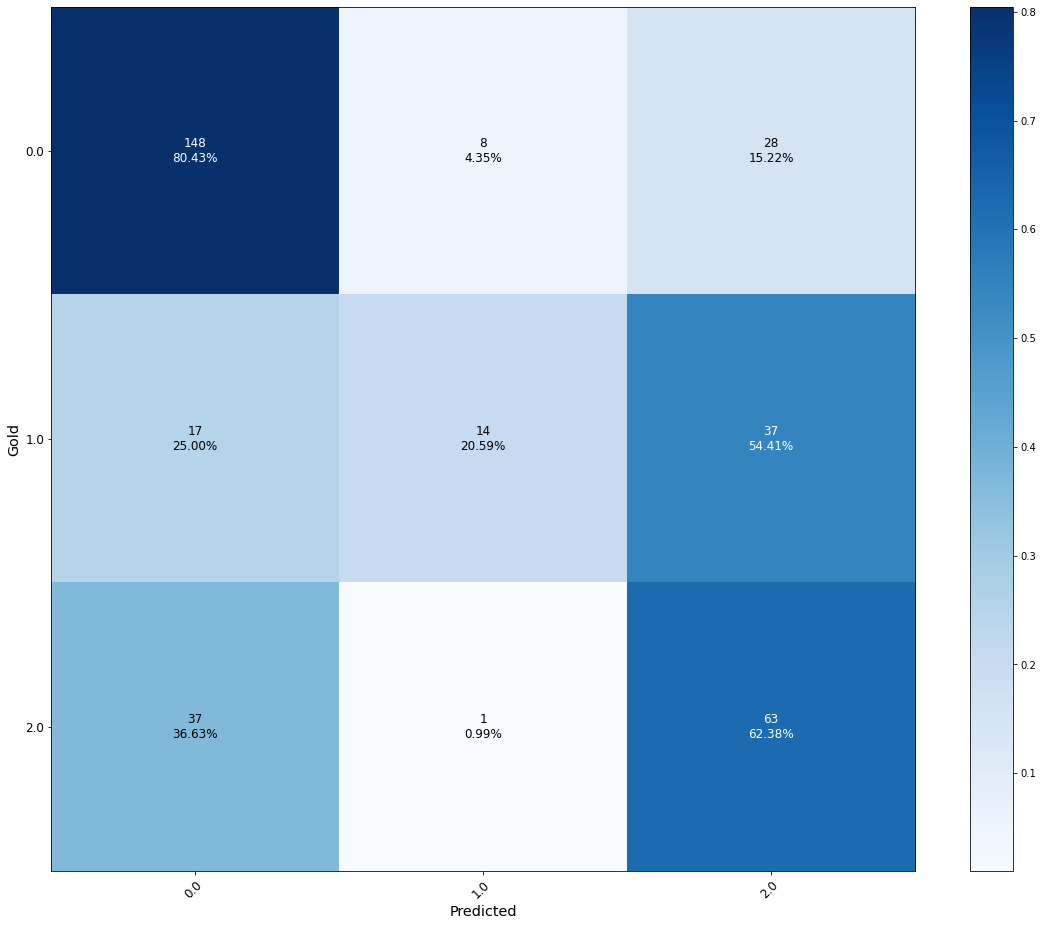

In [4]:
plot_scores_confusion_matrix(second_path / 'results/DeepPavlov-bert-base-cased-conversational_1/scores.csv', 'cm_2')

[0.0, 1.0, 2.0]


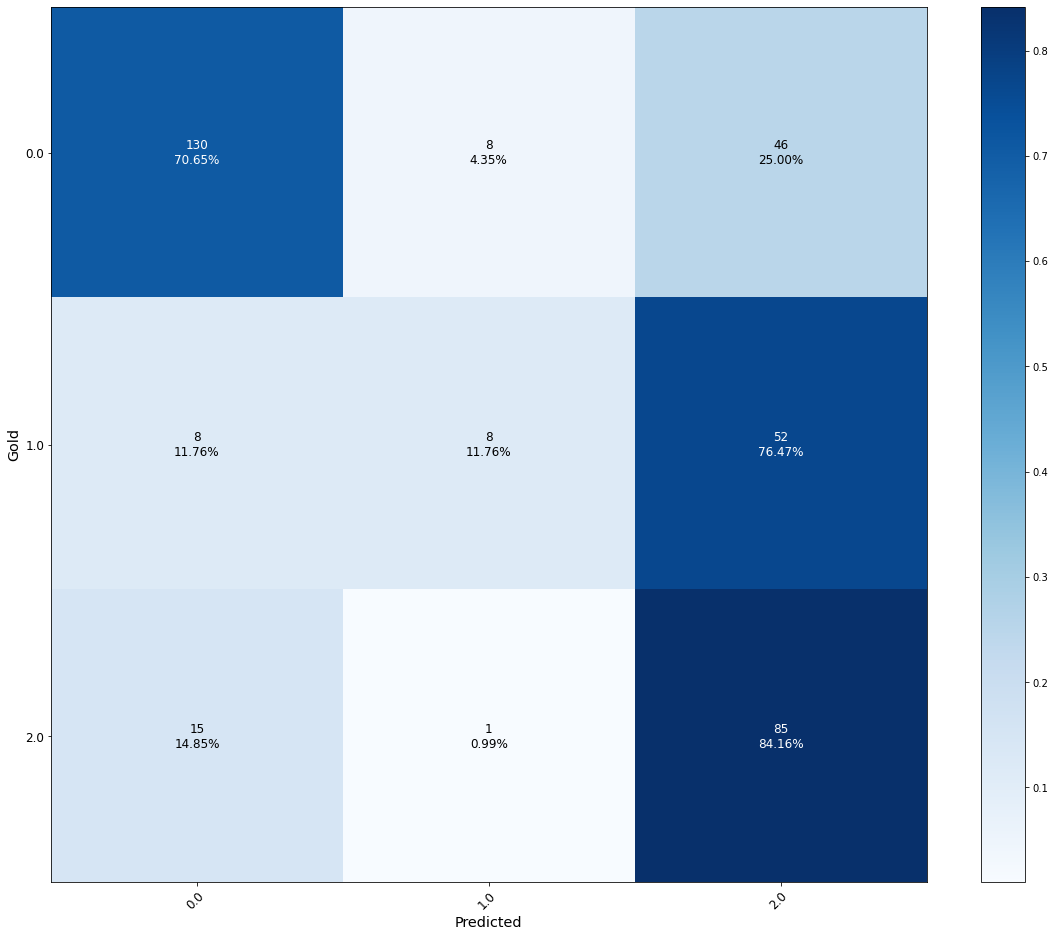

In [5]:
plot_scores_confusion_matrix(second_path / 'results_cleaned/DeepPavlov-bert-base-cased-conversational_best_1/scores.csv', 'cm_cleaned_best')

[0.0, 1.0, 2.0]


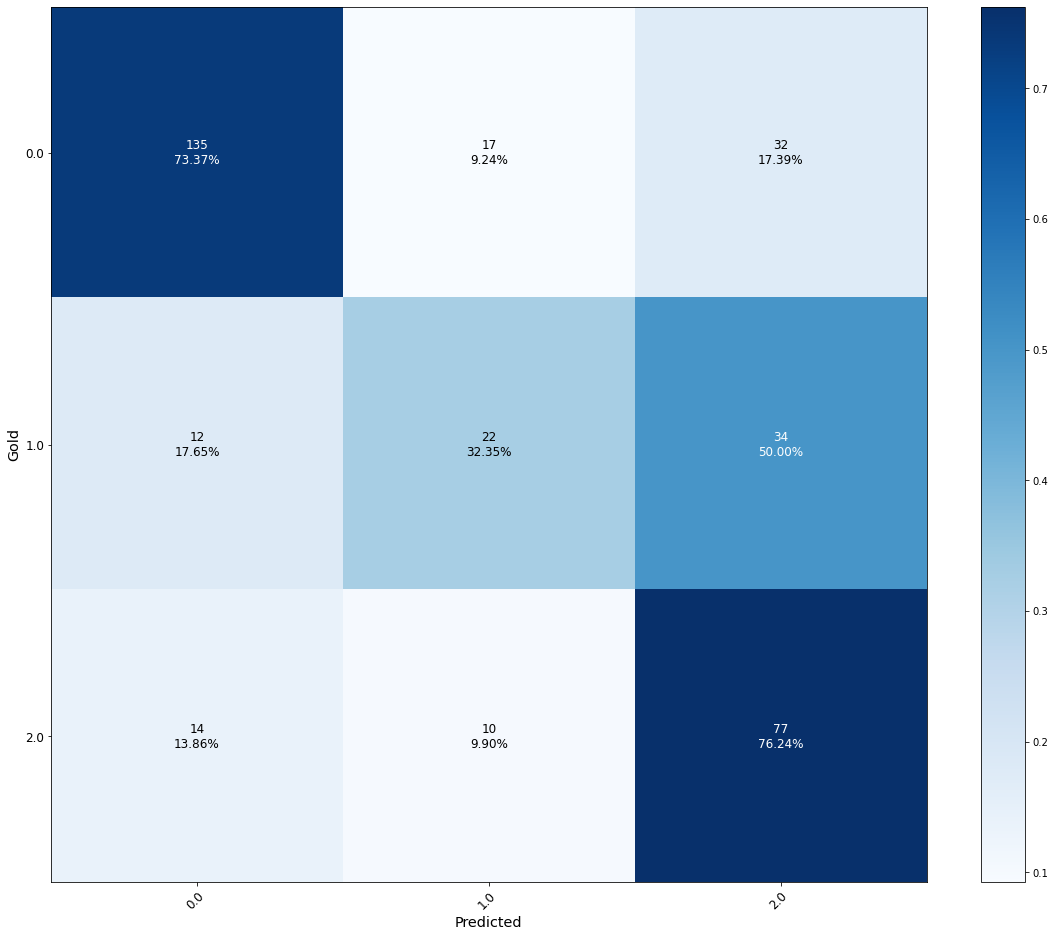

In [17]:
plot_scores_confusion_matrix(second_path / 'results_cleaned/DeepPavlov-bert-base-cased-conversational_1/scores.csv', 'cm_cleaned')

[0.0, 1.0, 2.0]


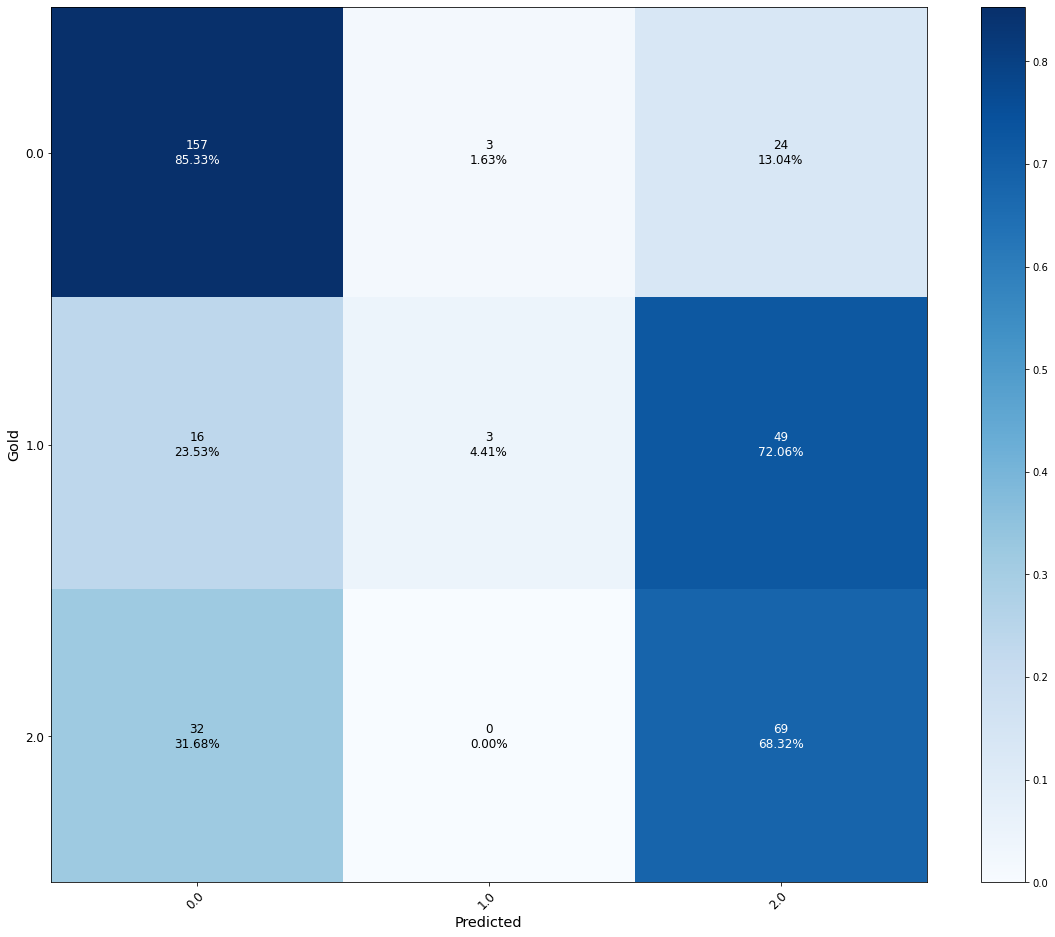

In [6]:
plot_scores_confusion_matrix(second_path / 'results_cleaned/cardiffnlp-twitter-roberta-base_1/scores.csv', 'cm_twitter_cleaned')

[0.0, 1.0, 2.0]


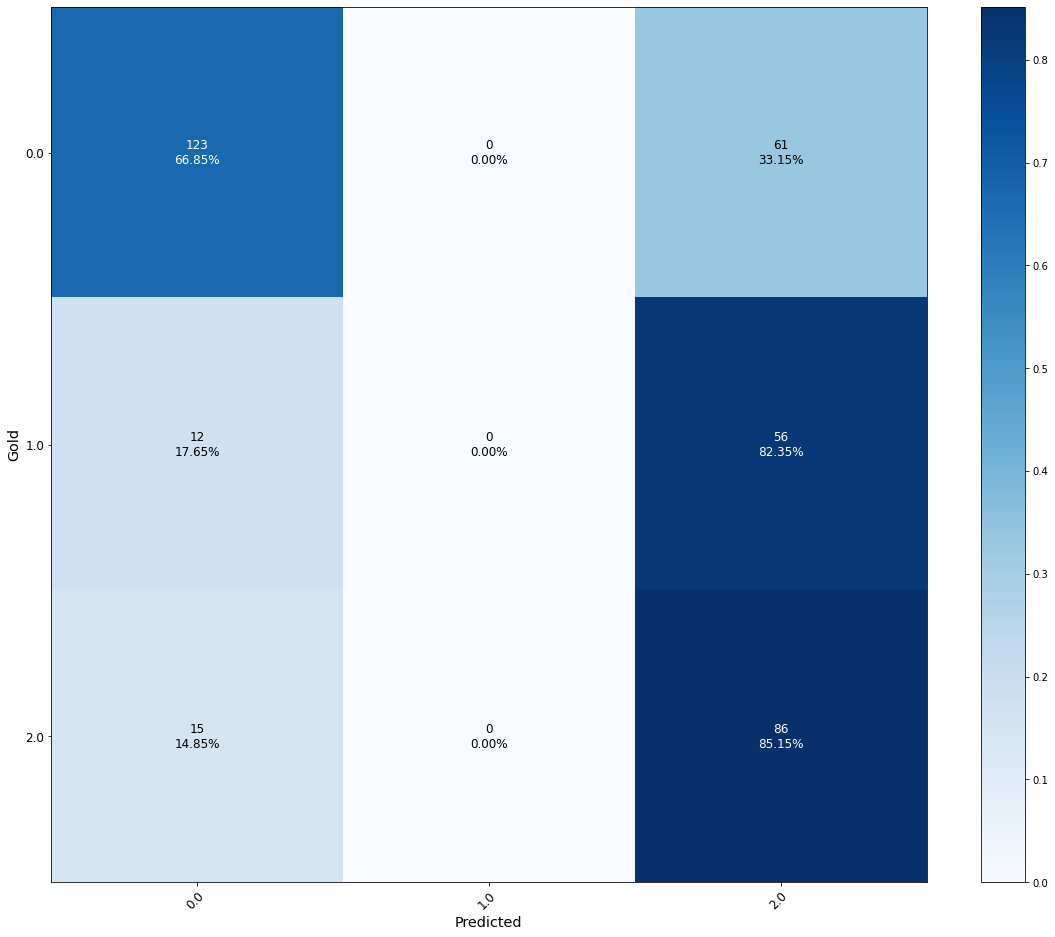

In [7]:
plot_scores_confusion_matrix(second_path / 'results/cardiffnlp-twitter-roberta-base_1/scores.csv', 'cm_twitter')

[0.0, 1.0, 2.0]


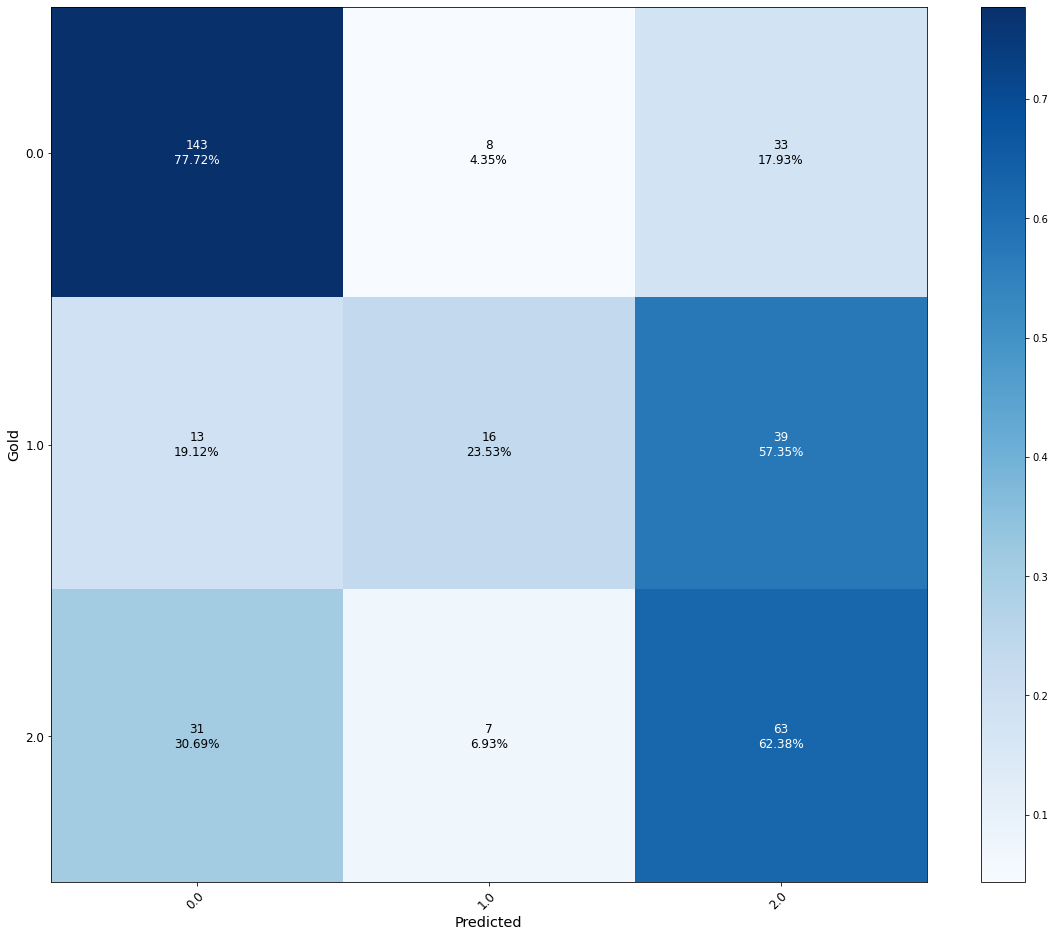

In [8]:
plot_scores_confusion_matrix(second_path / 'results_cleaned/bert-base-uncased_1/scores.csv', 'cm_bert_cleaned')

[0, 1]


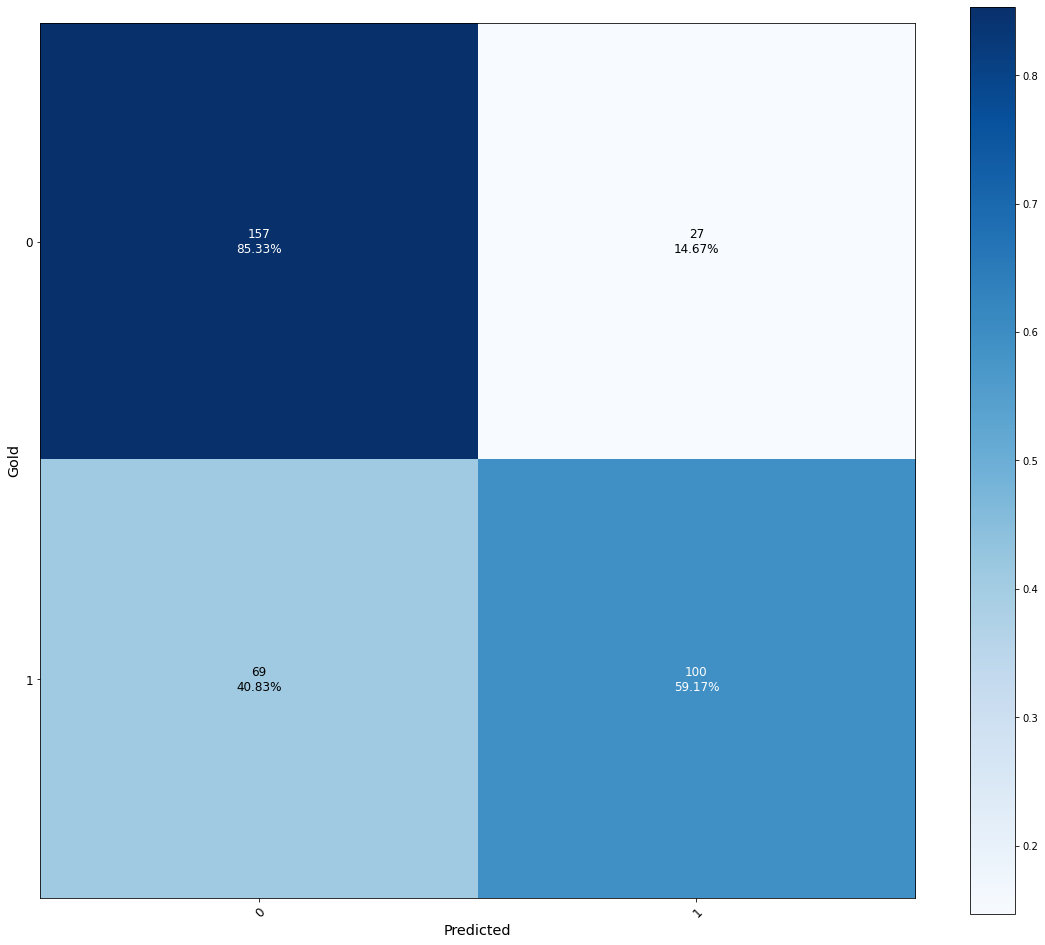

In [15]:
plot_scores_confusion_matrix(third_path / 'results_cleaned_bundled/DeepPavlov-bert-base-cased-conversational_1/scores.csv', 'cm_cleaned_3')

[0, 1]


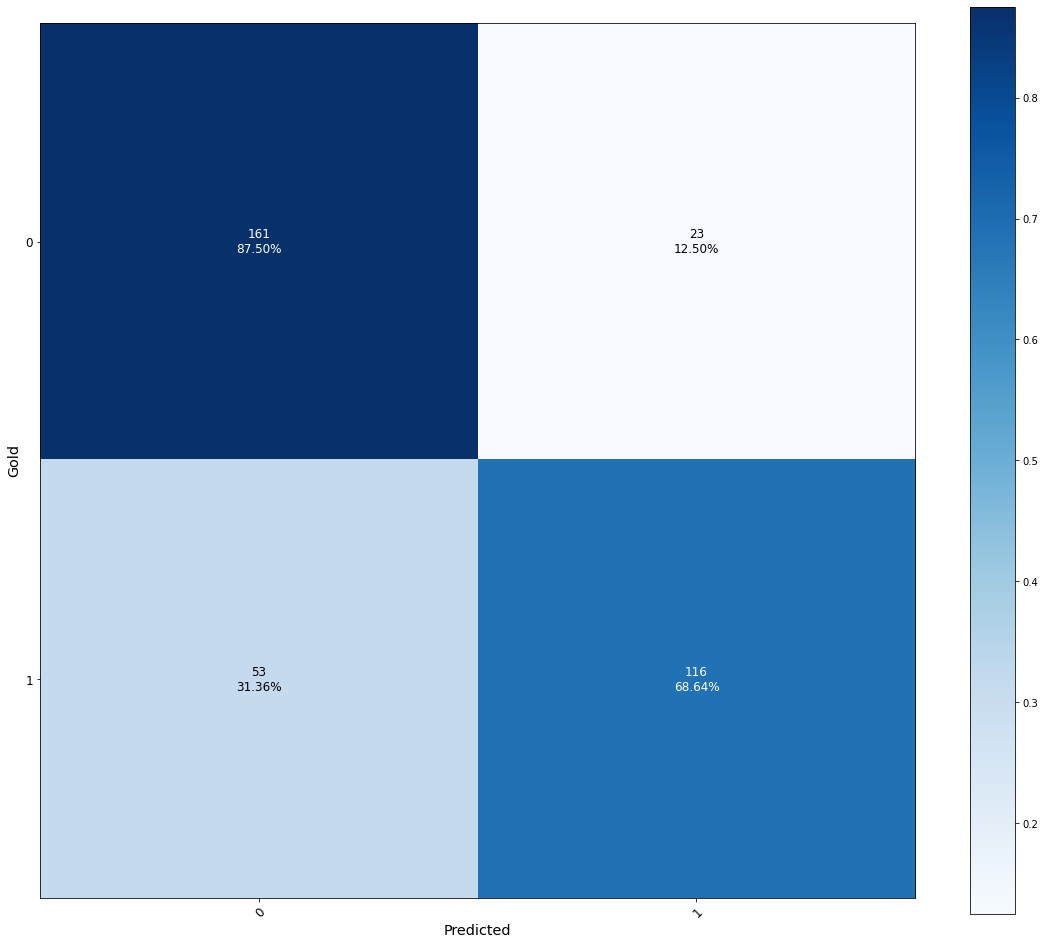

In [16]:
plot_scores_confusion_matrix(third_path / 'results_cleaned_bundled-lr3e5/DeepPavlov-bert-base-cased-conversational_1/scores.csv', 'cm_cleaned_3_lr3e5')

In [35]:
scores_df = load_scores(third_path / 'results_cleaned_bundled-lr3e5/DeepPavlov-bert-base-cased-conversational_1/scores.csv')
scores_df

,labels,text,raw_text,score,predicted
0,1,oh my god . mr cockroach . pls are the boko ha...,@olise_c @USEmbassyAbuja @Mazianozie @NigAirFo...,"[0.07113817120067283, 0.9288618287993271]",1
1,0,my christian borders ( gospel artist ) buzzd m...,My Christian borders(gospel artist) buzzd me u...,"[0.12012881005384286, 0.8798711899461571]",1
2,1,should worry his southern christian morons .,@RealOlaudah Should worry his southern Christi...,"[0.06590479361244143, 0.9340952063875586]",1
3,1,when will black lives matter speak about the d...,When will Black Lives Matter speak about the d...,"[0.764715947741034, 0.23528405225896598]",0
4,1,rt : please help christians and biafra . rejec...,RT @OluchiUkadike: Please help Christians and ...,"[0.875094818578976, 0.12490518142102404]",0
...,...,...,...,...,...
348,0,rt : i am a great admirer of the “ live and le...,RT @ChifeDr: I am a great admirer of the “live...,"[0.9745803476190713, 0.025419652380928616]",0
349,1,"show me a typical yoruba gurl , and i will sho...","show me a typical yoruba gurl,and i'll show yo...","[0.9089417211068199, 0.09105827889318016]",0
350,1,i never see a yoruba so dumb as you in a life ...,@GaniyuIsiaq2 @NigeriaNewsdesk @PDP_2023 @Naij...,"[0.09073548763985106, 0.9092645123601492]",1
351,0,rt : driving hours to go and see ordinary man ...,RT @OgbeniDipo: Driving 2 hours to go and see ...,"[0.9768907222638489, 0.023109277736151262]",0


In [37]:
display_full(scores_df[(scores_df['predicted'] == 0) & (scores_df['labels'] == 1)][['labels', 'raw_text', 'score', 'predicted']])

,labels,raw_text,score,predicted
3,1,"When will Black Lives Matter speak about the daily persecution of Christians in Africa, especially Nigeria? The Islamist Extremist fanatic Fulani Tribe of Buhari is literally video recording their rape of Christian women in public and sharing it on social media.\n@Imamofpeace","[0.764715947741034, 0.23528405225896598]",0
4,1,RT @OluchiUkadike: Please help Christians and BIAFRA.\n\n#RejectNigeria to stop Christian genocides in Zooniger-area.\n\nIbrahim Magu is a dog,"[0.875094818578976, 0.12490518142102404]",0
5,1,"Nigeria speaks about 520 languages and by origin, I am from the Eastern part, born in the Northern half, and live now in the Western side. I am well travelled and learned in it's culture. It's diversity and perplexity, whores and flaws are all I live to write for.","[0.9716178771000952, 0.02838212289990485]",0
6,1,"@EevsfD @KennedyNwogu4 @capo_bbg Yes, let it sink into your skull, no truth Igbo man or woman want to force you into biafra, ok. We are called Igbos, self sufficient not parasite.","[0.9573974575313207, 0.042602542468679255]",0
9,1,Fulani herdsmen declare Jihad in letter to Bishop Oyedepo [VIDEO] https://t.co/OuPGnvgi53,"[0.979648185444372, 0.020351814555628168]",0
11,1,"9 Fulani herdsmen gang-rape 15-yr-old girl, 2 housewives http://t.co/CMMUGqilfh","[0.978955434206039, 0.021044565793961023]",0
15,1,"Gov Ortom is eyeing tenure extension throughout the backdoor by using his pet project, FULANI HERDSMEN!???. \nThe bobo will be shock if he finds out that he will have to handover to a successor on May 29th, 2023???! His eyes go clear, one time! https://t.co/B1I1KgQLdt","[0.9647556734065347, 0.03524432659346517]",0
17,1,RT @iykimo: Why are people afraid to mention the groups and people responsible for food inflation?\n\nFulani herdsmen grazing on farms and ki,"[0.8618873221857873, 0.13811267781421274]",0
28,1,"suddenly,\nFulani herdsmen are no longer attacking villages;\nAll Fulanis are no longer killer herdsmen;\nHausa Fulanis are no longer ""Born to Rule"";\nIslamizing Nigeria is no longer being revealed to the politicians on... https://t.co/ru6E5fpIS0","[0.9745803476190713, 0.025419652380928616]",0
31,1,RT @Amaka_Ekwo: @Un @nnamdikanu1 \nDo you hate us that much to abandon us with Hausa/Fulani tribe?\nSelf-governance for Biafra.#Freedom\nhttp:,"[0.9772842436755207, 0.02271575632447913]",0


In [ ]:
scores_df

# Version 4

[0, 1]


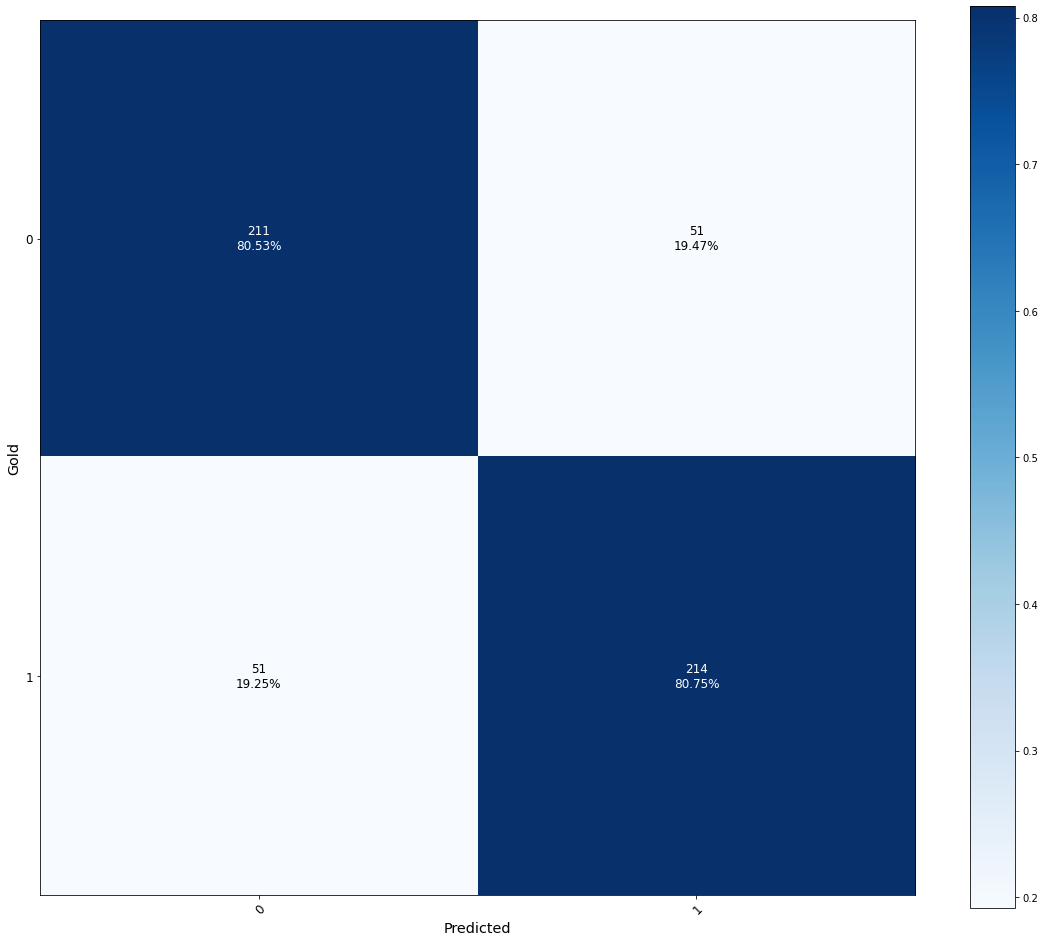

In [102]:
plot_scores_confusion_matrix(fourt_path / 'results_bundled_lr2e5/vinai-bertweet-base_1/scores.csv', 'cm_bundled_bertweet_4')

[0, 1, 2]


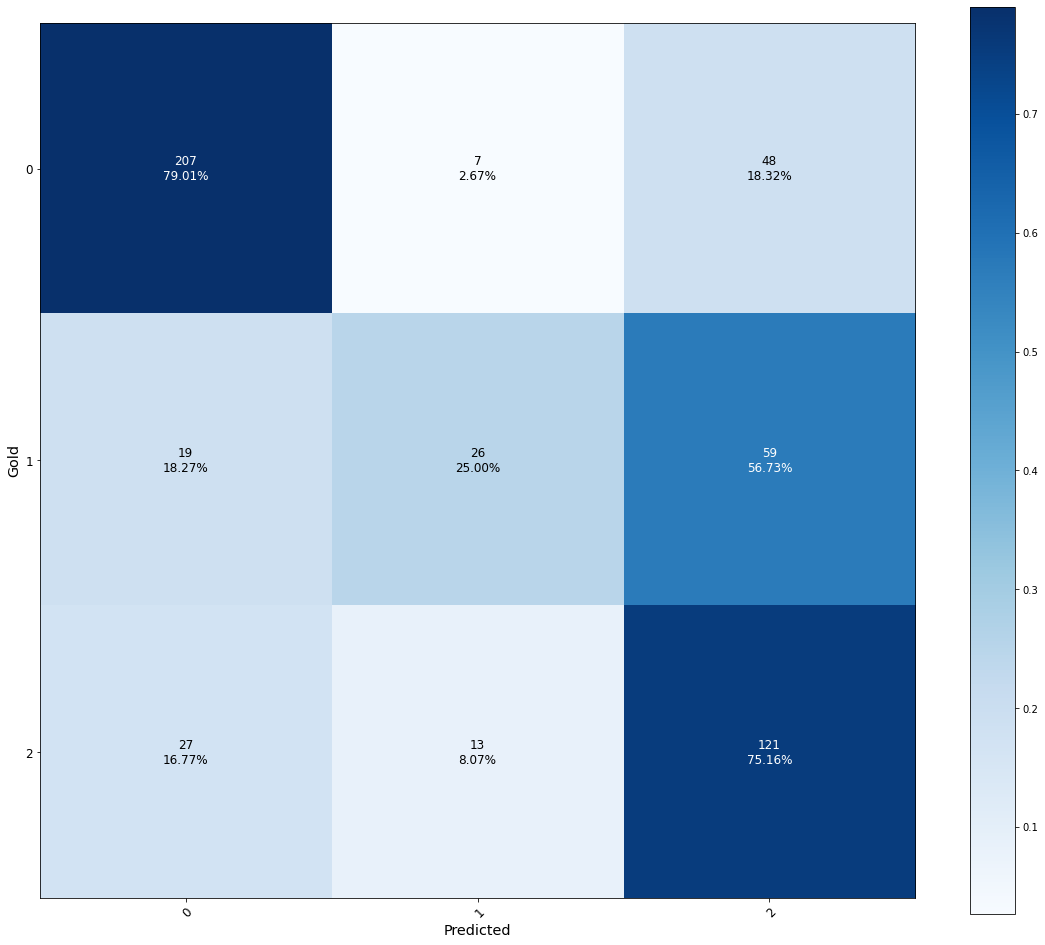

In [101]:
plot_scores_confusion_matrix(fourt_path / 'results_lr2e5/vinai-bertweet-base_1/scores.csv', 'cm_bertweet_4')

In [98]:
dump_prediction_errors(fourt_path / 'results_cleaned_bundled/DeepPavlov-bert-base-cased-conversational_1', '../labels/processed/initial_test/errors_v4.csv')

,labels,raw_text,score,predicted
3,0,"My Christian borders(gospel artist) buzzd me up saying am a worldly singer.But..Him dy smoke igbo,dy drink shayo pass me,e dy lash choir gals,e dy carry olosho,e dy do gee,e get sugar mummy.Abeg na who ur gospel song done help.bro u must b a mad idiot.sense dey pain u. Werey oshi","[0.11833414435630166, 0.8816658556436984]",1
5,1,"Nigeria speaks about 520 languages and by origin, I am from the Eastern part, born in the Northern half, and live now in the Western side. I am well travelled and learned in it's culture. It's diversity and perplexity, whores and flaws are all I live to write for.","[0.6042967632299602, 0.3957032367700398]",0
7,1,@channelstv The solution is very simple . Support the igbo masses to restore biafra then peace will return to the region. The igbos want equal rights and justice. COCONUT HEAD GOVERNORS,"[0.6134970921472432, 0.38650290785275676]",0
9,1,Fulani herdsmen declare Jihad in letter to Bishop Oyedepo [VIDEO] https://t.co/OuPGnvgi53,"[0.9354055426116176, 0.06459445738838242]",0
11,1,"9 Fulani herdsmen gang-rape 15-yr-old girl, 2 housewives http://t.co/CMMUGqilfh","[0.9382372910349689, 0.061762708965031006]",0
...,...,...,...,...
489,0,"@jeyleekrane All this groups alqeada ,isis,bolo Haram all are groups with that pretend to be Muslim but they re mostly unbebealivers they just use the name of Islam nd do what ever shit they like","[0.13285169778105557, 0.8671483022189443]",1
501,0,When you were crying the blood of the baboons and dogs did they arrest you?? When u shouted that it was a grand attempt to kill northern youths in the name fight against insurgence where u incarcerated?? Please your movie at Dapchi was a flop. Better script next time! https://t.co/wVKn6CpTFH,"[0.10946754782734448, 0.8905324521726555]",1
504,0,@benmurraybruce TY Danjuma lacks the moral authority to speak on this matter because he was deeply involved in the 1960's killings of the Southerners... It's a Frankenstein affair!,"[0.3386783595543936, 0.6613216404456064]",1
514,0,"#Buzzzii Baboon Rapes Female Teachers, Steals Their Panties http://t.co/MndEjXh4TW","[0.08582413880706131, 0.9141758611929387]",1


In [99]:
dump_prediction_errors(fourt_path / 'results_bundled_lr2e5/vinai-bertweet-base_1', '../labels/processed/initial_test/errors_v4.csv')

,labels,text,score,predicted
2,1,"@BlewynA @cazyp @miqdaad I'm sorry to say but that's a really dumb thing to do, I can equally pick the New Zealand mosque shooter and say he represent Christianity because he identifies as a Christian. By the way there are Muslims who don't believe what ur friends do, so would you say they aren't Muslims","[0.8766871718479847, 0.12331282815201539]",0
3,0,"My Christian borders(gospel artist) buzzd me up saying am a worldly singer.But..Him dy smoke igbo,dy drink shayo pass me,e dy lash choir gals,e dy carry olosho,e dy do gee,e get sugar mummy.Abeg na who ur gospel song done help.bro u must b a mad idiot.sense dey pain u. Werey oshi","[0.12984343802049797, 0.870156561979502]",1
5,1,"Nigeria speaks about 520 languages and by origin, I am from the Eastern part, born in the Northern half, and live now in the Western side. I am well travelled and learned in it's culture. It's diversity and perplexity, whores and flaws are all I live to write for.","[0.9358173563909802, 0.0641826436090197]",0
9,1,Fulani herdsmen declare Jihad in letter to Bishop Oyedepo [VIDEO] https://t.co/OuPGnvgi53,"[0.9364595541804993, 0.06354044581950083]",0
11,1,"9 Fulani herdsmen gang-rape 15-yr-old girl, 2 housewives http://t.co/CMMUGqilfh","[0.933673125976404, 0.06632687402359619]",0
...,...,...,...,...
475,1,"RT @xjesswalkerr: hot girls are born in may, june, july and august","[0.9214283492343645, 0.07857165076563562]",0
478,0,"@Bulamacartoons Dumb fool tagging Yoruba Yahoo..... Shey na OYINBO you dey fight for 🙄,\nOr OYINBO com complain for yr station.\nYour clansmen that parade the whole country killing and kidnapping just because of cow.\nU must be mentally derailled for posting this","[0.12283853544300478, 0.8771614645569954]",1
489,0,"@jeyleekrane All this groups alqeada ,isis,bolo Haram all are groups with that pretend to be Muslim but they re mostly unbebealivers they just use the name of Islam nd do what ever shit they like","[0.2668346285944962, 0.7331653714055036]",1
501,0,When you were crying the blood of the baboons and dogs did they arrest you?? When u shouted that it was a grand attempt to kill northern youths in the name fight against insurgence where u incarcerated?? Please your movie at Dapchi was a flop. Better script next time! https://t.co/wVKn6CpTFH,"[0.20882357113887368, 0.7911764288611264]",1


In [103]:
dump_prediction_errors(fourt_path / 'results_lr2e5/vinai-bertweet-base_1', '../labels/processed/initial_test/errors_nonbundled_v4.csv')

,labels,text,score,predicted
2,1,"@BlewynA @cazyp @miqdaad I'm sorry to say but that's a really dumb thing to do, I can equally pick the New Zealand mosque shooter and say he represent Christianity because he identifies as a Christian. By the way there are Muslims who don't believe what ur friends do, so would you say they aren't Muslims","[0.6191547282154107, 0.16713216285244467, 0.21371310893214462]",0
3,0,"My Christian borders(gospel artist) buzzd me up saying am a worldly singer.But..Him dy smoke igbo,dy drink shayo pass me,e dy lash choir gals,e dy carry olosho,e dy do gee,e get sugar mummy.Abeg na who ur gospel song done help.bro u must b a mad idiot.sense dey pain u. Werey oshi","[0.0839068944843728, 0.37320931398320173, 0.5428837915324255]",2
4,1,RT @OluchiUkadike: Please help Christians and BIAFRA.\n\n#RejectNigeria to stop Christian genocides in Zooniger-area.\n\nIbrahim Magu is a dog�,"[0.16452624692149143, 0.3451278195252831, 0.49034593355322564]",2
5,2,"Nigeria speaks about 520 languages and by origin, I am from the Eastern part, born in the Northern half, and live now in the Western side. I am well travelled and learned in it's culture. It's diversity and perplexity, whores and flaws are all I live to write for.","[0.7874814679696436, 0.06084276799670276, 0.1516757640336536]",0
6,1,"@EevsfD @KennedyNwogu4 @capo_bbg Yes, let it sink into your skull, no truth Igbo man or woman want to force you into biafra, ok. We are called Igbos, self sufficient not parasite.","[0.18288655480340232, 0.17109443420442852, 0.6460190109921693]",2
...,...,...,...,...
501,0,When you were crying the blood of the baboons and dogs did they arrest you?? When u shouted that it was a grand attempt to kill northern youths in the name fight against insurgence where u incarcerated?? Please your movie at Dapchi was a flop. Better script next time! https://t.co/wVKn6CpTFH,"[0.2751514853010432, 0.30600900396779246, 0.41883951073116427]",2
503,1,@Bellomatawalle1 @PoliceNG @MBuhari @HQNigerianArmy @elrufai Useless Governor Nigerians are Ready for the Fight. Gone are those days Southerners Run. This time it's a religious One. So bring in your Dogs and Let the Dogs and The Baboon be Soaked in Blood..Like buhari has said it https://t.co/vXfXjCrKCm,"[0.09133186808363412, 0.2731496447415806, 0.6355184871747852]",2
506,1,@SaharaReporters @GarShehu The stupid Garba Ewu should respect southern governors and respect the peoples decisions too.,"[0.15801640890487959, 0.3151944040315561, 0.5267891870635643]",2
520,0,#YouAreAFoolIf girl chop your money nd u no even knack one round,"[0.21078326813007486, 0.30625761649157485, 0.48295911537835046]",2


In [35]:
compute_average_evaluation_cv(model_path=Path(fifth_path / 'results_lr2e5_cv/vinai-bertweet-base'))

Evaluation for vinai-bertweet-base, fold 0


Unnamed: 0    avg / total
precision        0.708691
recall           0.721591
f1-score         0.698629
support             176.0
pred                176.0
AUC              0.869674
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 1


Unnamed: 0    avg / total
precision        0.653856
recall           0.693182
f1-score         0.663085
support             176.0
pred                176.0
AUC              0.811863
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 2


Unnamed: 0    avg / total
precision        0.729159
recall           0.727273
f1-score         0.727996
support             176.0
pred                176.0
AUC              0.867061
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 3


Unnamed: 0    avg / total
precision        0.704291
recall           0.710227
f1-score         0.706786
support             176.0
pred                176.0
AUC              0.828814
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 4


Unnamed: 0    avg / total
precision        0.685759
recall           0.681818
f1-score         0.665927
support             176.0
pred                176.0
AUC              0.846914
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 5


Unnamed: 0    avg / total
precision        0.753322
recall           0.744318
f1-score         0.745067
support             176.0
pred                176.0
AUC               0.87773
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 6


Unnamed: 0    avg / total
precision        0.669718
recall           0.647727
f1-score         0.641309
support             176.0
pred                176.0
AUC              0.832648
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 7


Unnamed: 0    avg / total
precision        0.686521
recall           0.664773
f1-score         0.649954
support             176.0
pred                176.0
AUC              0.863425
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 8


Unnamed: 0    avg / total
precision        0.567055
recall           0.628571
f1-score         0.579335
support             175.0
pred                175.0
AUC              0.818676
Name: 3, dtype: object

Evaluation for vinai-bertweet-base, fold 9


Unnamed: 0    avg / total
precision          0.6341
recall               0.64
f1-score         0.614181
support             175.0
pred                175.0
AUC              0.799135
Name: 3, dtype: object

,precision,AUC
count,10.000000,10.000000
mean,0.679247,0.841594
std,0.052629,0.027291
min,0.567055,0.799135
25%,0.657821,0.821211
50%,0.686140,0.839781
75%,0.707591,0.866152
max,0.753322,0.877730


In [38]:
dump_cv_prediction_errors(model_path=Path(fifth_path / 'results_lr2e5_cv/vinai-bertweet-base'), 
                          output_path='../labels/processed/initial_test/errors_v5_cv.csv')

/tmp/ipykernel_2375940/2905010780.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors_df['fold'] = fold


,labels,text,score,predicted
0,2,@olise_c @USEmbassyAbuja @Mazianozie @NigAirForce @USAfricaCommand @SierraNevCorp @embraer Oh my God...Mr cockroach...pls are the Boko haram Christians?...why do you have to internationalize your stupidity... Do your Biafra thing without lies pls.,"[0.08002366729475305, 0.519785476938145, 0.40019085576710184]",1
2,1,@channelstv The solution is very simple . Support the igbo masses to restore biafra then peace will return to the region. The igbos want equal rights and justice. COCONUT HEAD GOVERNORS,"[0.07600549767052736, 0.3454063987160569, 0.5785881036134158]",2
4,0,"RT @Beautiful_Nubia: We're supposed to think that the problems with Nigeria are killer Fulani herdsmen, rabblerousing Yoruba thug-statesmen�","[0.33152002081529236, 0.09664284634185613, 0.5718371328428514]",2
8,2,"RT @General_Somto: For Days Now, The Nigerian Armed Forces Has Failed To Arrest Or Track Down The Killer Fulani Herdsmen That Slaughtered O�","[0.6769480265743973, 0.06126757516687472, 0.26178439825872785]",0
14,2,"RT @Amaka_Ekwo: Biafra : No Election In Anambra, Igbo Leaders Are Liars � IPOB Insists, Reveals What Nnamdi Kanu Discussed With... https://�","[0.8996241064852883, 0.03816125624938237, 0.062214637265329484]",0
...,...,...,...,...
161,1,"@lanthimos_fan Would rather watch the lesbian back passer, plus don’t need some of that La Fabrica scum 👍","[0.2638722628027576, 0.193903316112595, 0.5422244210846474]",2
166,1,@emacofficial Omo see useless talk. Qurix received insults upon insults o because that year admission hard die. Nobe even now we dey see small admission for southern kaduna???\n\nBastard get mind call person Bigot,"[0.05075132003234127, 0.4046852089674153, 0.5445634710002435]",2
168,0,"@Gagzy_08 @MobilePunch Yet under him southern Kaduna people were murdered like cockroaches.\nSee ehn, if that man ever becomes president Buhari will be a saint compared to him","[0.10390819622555375, 0.3732753587338269, 0.5228164450406194]",2
170,2,"RT @amerix: Men,\n\nYour woman wants to feel your fearlessness and commanding demeanor.\n\nShe may show resistance but that is a shit test.\n\nSh…","[0.8935590817854415, 0.05055905929268829, 0.05588185892186996]",0
